## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Define Paths & Parameters

In [2]:
train_dir = 'train'
test_dir = 'test'
val_dir = 'val'

BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

## Load Dataset

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

class_names = train_ds.class_names

Found 9246 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


## Show Sample Images

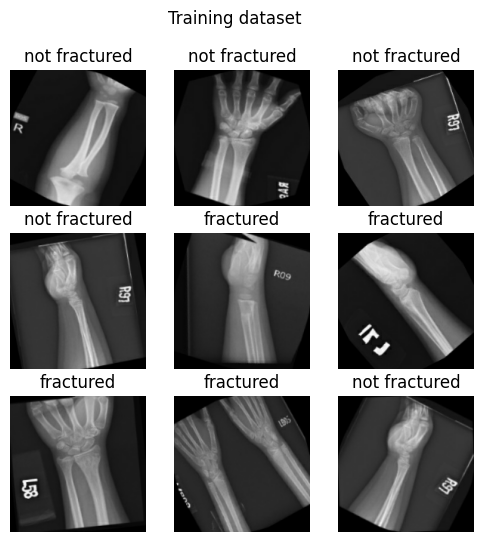

In [4]:
def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(train_ds, 'Training dataset')

## Plot Class Distribution

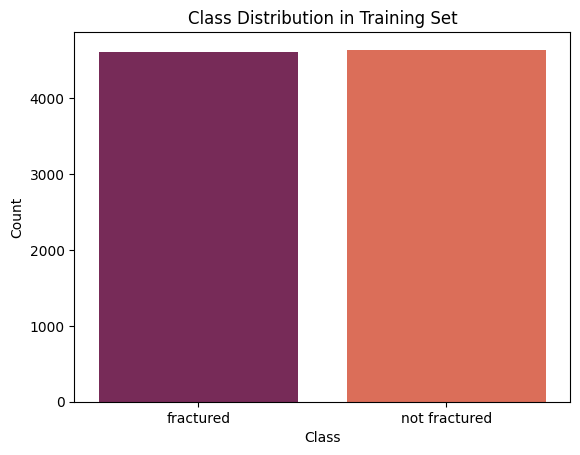

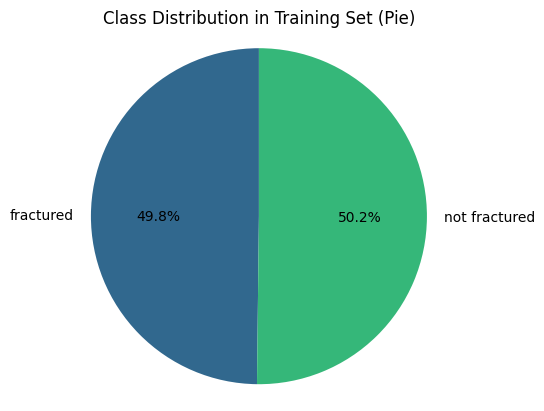

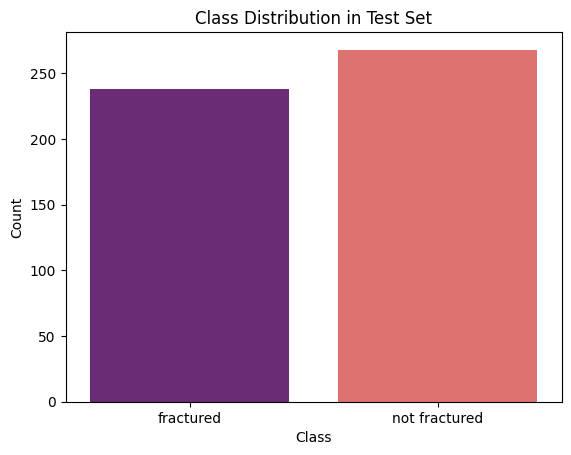

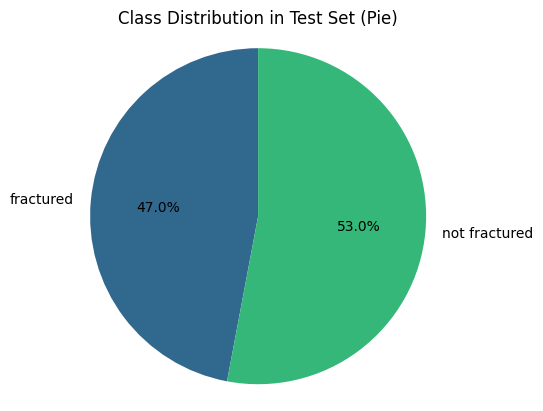

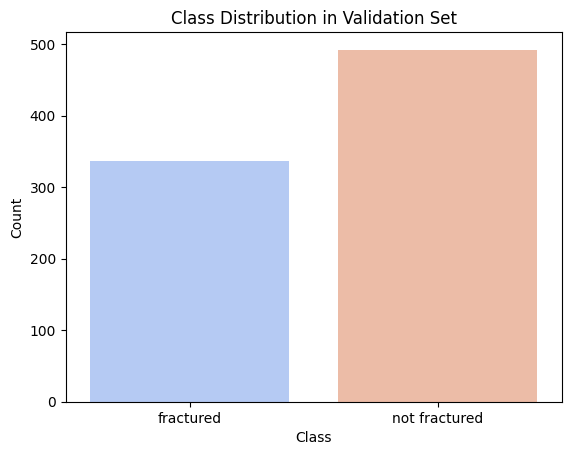

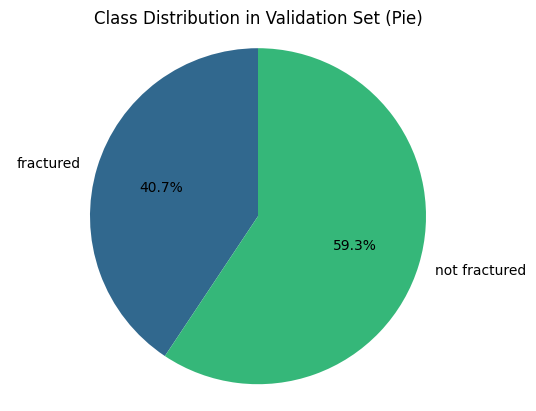

In [5]:
def count_classes(dataset, class_name):
    dataset_path = Path(dataset)
    return len(list(dataset_path.glob(f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class': [], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def plot_class_pie_chart(df, title):
    plt.pie(df['count'], labels=df['class'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(df)))
    plt.title(title)
    plt.axis('equal')
    plt.show()

train_df = create_class_counts_df(train_dir, class_names)
test_df = create_class_counts_df(test_dir, class_names)
val_df = create_class_counts_df(val_dir, class_names)

plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')
plot_class_pie_chart(train_df, 'Class Distribution in Training Set (Pie)')
plot_class_distribution(test_df, 'Class Distribution in Test Set', palette='magma')
plot_class_pie_chart(test_df, 'Class Distribution in Test Set (Pie)')
plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='coolwarm')
plot_class_pie_chart(val_df, 'Class Distribution in Validation Set (Pie)')

## Data Generators(Augmentation)

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, class_mode='binary')
test_set = train_datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, class_mode='binary')
val_set = train_datagen.flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, class_mode='binary')

Found 9246 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


## Model Architecture

In [7]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

GPU is not available


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,697,345 (21.73 MB)

 Trainable params: 5,697,345 (21.73 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train Model

In [9]:
tf.debugging.set_log_device_placement(True)

history = model.fit(training_set,
                    validation_data=val_set,
                    epochs=3,
                    batch_size=BATCH_SIZE)

Epoch 1/3
289/289 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.6264 - loss: 0.6474 - val_accuracy: 0.8311 - val_loss: 0.4487
Epoch 2/3
289/289 ━━━━━━━━━━━━━━━━━━━━ 230s 796ms/step - accuracy: 0.8551 - loss: 0.3479 - val_accuracy: 0.8685 - val_loss: 0.4050
Epoch 3/3
289/289 ━━━━━━━━━━━━━━━━━━━━ 228s 788ms/step - accuracy: 0.9259 - loss: 0.2029 - val_accuracy: 0.8709 - val_loss: 0.3683


## Evaluate Model

In [10]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 997ms/step - accuracy: 0.8708 - loss: 0.2946
Test Accuracy: 0.89
Test Loss: 0.28


## Plot Accuracy and Loss

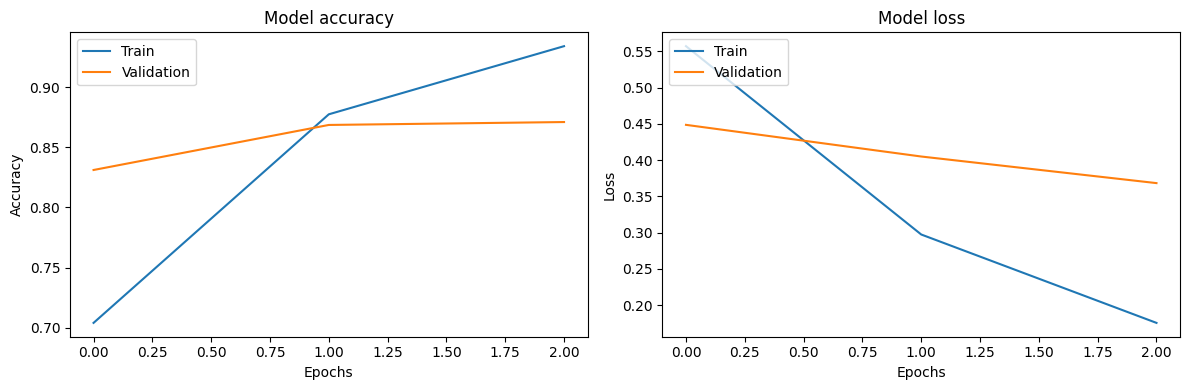

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

## Save & Load Model

In [12]:
model.save('fracture_classification_model.h5')
loaded_model = tf.keras.models.load_model('fracture_classification_model.h5')

## Preprocess & Predict Custom Image

In [13]:
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = 'val/not fractured/IMG0004389.jpg'
preprocessed_img = load_preprocessed_image(image_path)

predictions = loaded_model.predict(preprocessed_img)
predicted_class = (predictions < 0.5).astype("int32")
class_names = ['fractured', 'not fractured']

print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Predicted class: fractured
